### Solving Aiyagari (1994) model
#### 07/2019

#### Calibrating the Markov process


We need to calibrate the markov process so that:

\begin{equation}
\begin{bmatrix}
e & u
\end{bmatrix}
\begin{bmatrix}
\pi_{ee} & \pi_{eu} \\
\pi_{ue} & \pi_{uu}
\end{bmatrix} = \begin{bmatrix}
e & u
\end{bmatrix}
\end{equation}

with $e = 0.9 \text{ and } \pi_{ee} = 0.9$

We get that:
\begin{equation}
\begin{bmatrix}
\pi_{ee} & \pi_{eu} \\
\pi_{ue} & \pi_{uu}
\end{bmatrix} = \begin{bmatrix}
0.9 & 0.1 \\
0.9 & 0.1
\end{bmatrix}
\end{equation}

In [45]:
import numpy as np
from scipy import interpolate
import numba as nb

#Economic parameters
Π = np.array([[0.9,0.1], [0.9, 0.1]] )
Uss = 0.1
α = 0.36
β = 0.96
δ = 0.06



# Basic functions

# Return on capital
rf = lambda k,u: α*k**(α - 1) * (1 - u)** (1 - α )


# Return on labor
wf = lambda k,u: (1-α)*k**(α ) * (1 - u)** (- α )


#Aggregate labor supply
Lf = lambda u: 1 - u


#Utility
def u(c):
    if c > 0:
        return np.log(c)
    else:
        return -(10**8)


# Interpolant to evaluate Value Function
def interpolant(x,Kgrid,Vp):
    t = interpolate.interp1d(Kgrid,Vp, kind='linear', fill_value="extrapolate")
    return t(x)


def Bellman(Kp, *args):
    R, W, Kgrid, Vp, Ε, j, l, Π = args
    
    Today = u( (1 + R - δ)* Kgrid[j] + W*Ε[l] - Kp)
#     print("Value for Today", Today)
    exp= 0
    for i in range(Nϵ):
        exp +=  Π[l,i]*interpolant(Kp,Kgrid,Vp[:,i])  
    
    Value = Today + β * exp
        
    return - Value



def simulate(Kp, simuT, Π, Kstar, Kgrid):

    np.random.seed(seed=13)
    ϵ = np.random.binomial(1, Π[0,1], simuT)
    Ksimu = np.zeros([simuT])
    
    Ksimu[0] = Kstar

    for t in range(1,simuT):
        Ksimu[t] = interpolant(Ksimu[t-1], Kgrid, Kp[:,ϵ[t]])
    
    print(Ksimu)
    Kstar_new = np.mean(Ksimu[1:])
    
    return Kstar_new
    
Kstar = ( (1/β - 1+δ) /(α*(1-Uss)**(1-α))) ** (1 / (α - 1))
print(Kstar)

6.4900587533395635


#### Compute the steady state equilibrium for K

In [47]:
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from matplotlib import pyplot as plt


# Computational parameters
N = 30
Nϵ = 2
epsi = 1
epsi2 = 1
tol = 1e-5
maxiter = 2000
simuT = 2000


# Make grid
Klow   = 0.01
Khigh  = 10
Kgrid = np.linspace(Klow, Khigh, N)

#Steady State capital
Kstar = ( (1/β - 1+δ) /(α*(1-Uss)**(1-α))) ** (1 / (α - 1))
Ustar = Uss
Ε = np.array([1,0])


iter  = 0



def Aiyagari(Kstar, Ustar, Π, Ε, Kgrid, tol=1e-4,maxiter=2000, simuT=50):
    iter2 = 0
    epsi2 = 1
    Vp=Klow*np.ones([N,Nϵ])
    Kp= Klow*np.ones([N,Nϵ])
    Vp_new=np.zeros([N,Nϵ])
    Kp_new=np.zeros([N,Nϵ])
    while (epsi2 > tol) & (iter2 < maxiter):
        epsi = 1
        iter = 0
        # Dynamic Programming Step
        ##########################
        R = rf(Kstar, Ustar)
    #     print("Return ", R)
        W = wf(Kstar, Ustar)
    #     print("Wage ", W)

        while (epsi > tol) & (iter < maxiter):

            for j in range(N):

                for l in range(Nϵ):

                    params = R, W, Kgrid, Vp, Ε, j, l, Π
    #                 solve = minimize(Bellman,Kp[j,l], args=(params))
                    solve = minimize_scalar(Bellman, \
                          bounds=(Kgrid[j]*0.00001,Kgrid[j]*(1+R-δ)+W*Ε[l]), \
                          args=(params), method='bounded' )
                    Kp_new[j,l] = solve.x
                    Vp_new[j,l] = - solve.fun


            epsi = ((Vp_new - Vp) ** 2).sum()
            print("Error term for the Value Function: ", epsi)
            #Update
            Kp=Kp_new*0.5 + 0.5*Kp
            Vp = Vp_new*0.5 + 0.5*Vp

            iter=iter+1
        plt.plot(Kgrid, Kp_new[:,0])
        plt.plot(Kgrid, Kp_new[:,1])
        plt.show()
        plt.plot(Kgrid, Vp_new[:,0])
        plt.plot(Kgrid, Vp_new[:,1])
        plt.show()

        # Simulation step
        #################
        Kstar_new = simulate(Kp, simuT, Π, Kstar, Kgrid)
        print("New value for Kstar", Kstar_new)
        epsi2 = (Kstar_new - Kstar) ** 2
        print("Error term for Kstar: ", epsi2)
        Kstar = 0.5*Kstar_new + 0.5*Kstar
        Vp=Kstar*np.ones([N,Nϵ])
        iter2=iter2+1


    

Error term for the Value Function:  200.3354489034897
Error term for the Value Function:  75.74617919359308
Error term for the Value Function:  42.75757463333748
Error term for the Value Function:  27.56721523354714
Error term for the Value Function:  19.31038106845308
Error term for the Value Function:  14.318002285301263
Error term for the Value Function:  11.061611200523188
Error term for the Value Function:  8.81441326062167
Error term for the Value Function:  7.197080920967142
Error term for the Value Function:  5.996179060455483
Error term for the Value Function:  5.080278414726226
Error term for the Value Function:  4.367151388767942
Error term for the Value Function:  3.799960617626338
Error term for the Value Function:  3.34312146774148
Error term for the Value Function:  2.9684491618976128
Error term for the Value Function:  2.656774531284816
Error term for the Value Function:  2.3950268566337196
Error term for the Value Function:  2.1728605789622026
Error term for the Value 

Error term for the Value Function:  0.005908199918286257
Error term for the Value Function:  0.005679762556812854
Error term for the Value Function:  0.005460250839157365
Error term for the Value Function:  0.005249292940393837
Error term for the Value Function:  0.0050465822980904455
Error term for the Value Function:  0.004851786944897665
Error term for the Value Function:  0.004664597121171382
Error term for the Value Function:  0.004484698650593324
Error term for the Value Function:  0.004311813310584569
Error term for the Value Function:  0.004145667763379195
Error term for the Value Function:  0.0039860069064182385
Error term for the Value Function:  0.0038325609346136877
Error term for the Value Function:  0.0036851017439551064
Error term for the Value Function:  0.003543367548417442
Error term for the Value Function:  0.0034071649375781933
Error term for the Value Function:  0.0032762507586407315
Error term for the Value Function:  0.0031504383678769925
Error term for the Value

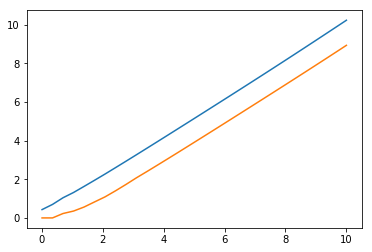

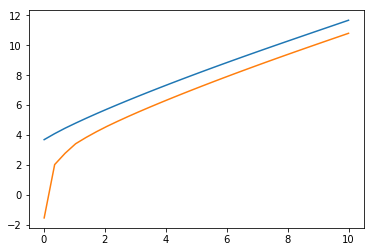

[6.49005875 6.62888874 6.76852708 5.66003928 4.55736219 4.69848158
 4.83872479 4.97810898 5.11690135 5.25510441 5.39287072 5.53031758
 5.66746245 5.80455622 5.94159889 6.07875323 6.21615252 6.35381081
 6.49205796 6.63089649 5.52272786 5.65987556 5.79697216 4.69315674
 4.83343301 4.97283967 5.11165441 5.24987975 5.38765818 5.52511712
 5.66226393 5.79935964 5.93640425 6.07354931 6.21093931 5.10440626
 5.24266237 5.38045753 5.51793318 5.65509004 5.79218842 5.9292357
 4.824453   4.96391409 5.10276673 5.2410298  5.37882875 5.51630817
 5.6534688  5.79056778]
New value for Kstar 5.553872586799278
Error term for Kstar:  0.8764445384213957
Error term for the Value Function:  161.24210916394355
Error term for the Value Function:  53.3012827376953
Error term for the Value Function:  26.565504588998813
Error term for the Value Function:  15.04267442405183
Error term for the Value Function:  9.238084989858447
Error term for the Value Function:  6.0228977645562605
Error term for the Value Function: 

Error term for the Value Function:  0.0015882455736222175
Error term for the Value Function:  0.0016391620965048128
Error term for the Value Function:  0.0016934193924407017
Error term for the Value Function:  0.0017510493865340042
Error term for the Value Function:  0.001812076748456905
Error term for the Value Function:  0.001876522534794401
Error term for the Value Function:  0.001944416389017577
Error term for the Value Function:  0.002015812209934133
Error term for the Value Function:  0.0020907551715968107
Error term for the Value Function:  0.002169287918341469
Error term for the Value Function:  0.0022514433293989704
Error term for the Value Function:  0.0023372744512856493
Error term for the Value Function:  0.0024268461517620277
Error term for the Value Function:  0.002520220615211256
Error term for the Value Function:  0.0026174486363238956
Error term for the Value Function:  0.0027185926093150404
Error term for the Value Function:  0.002823700664893126
Error term for the Va

Error term for the Value Function:  0.09015949610966652
Error term for the Value Function:  0.0917862146710829
Error term for the Value Function:  0.09343345372965521
Error term for the Value Function:  0.09510132347748412
Error term for the Value Function:  0.09678996259013237
Error term for the Value Function:  0.09849950947542405
Error term for the Value Function:  0.10023009259453496
Error term for the Value Function:  0.10198182920247491
Error term for the Value Function:  0.10375486196571745
Error term for the Value Function:  0.10554933250228776
Error term for the Value Function:  0.10736537133664087
Error term for the Value Function:  0.10920309515842797
Error term for the Value Function:  0.11106267111203537
Error term for the Value Function:  0.11294421958833296
Error term for the Value Function:  0.11484788258611632
Error term for the Value Function:  0.11677379773077058
Error term for the Value Function:  0.11872210264375636
Error term for the Value Function:  0.12069293356

Error term for the Value Function:  0.6382692726186112
Error term for the Value Function:  0.6447876386377258
Error term for the Value Function:  0.6513554245786677
Error term for the Value Function:  0.6579729144217403
Error term for the Value Function:  0.6646403920553828
Error term for the Value Function:  0.6713581414685098
Error term for the Value Function:  0.6781264470631028
Error term for the Value Function:  0.6849455940060554
Error term for the Value Function:  0.6918158685460789
Error term for the Value Function:  0.6987374743017343
Error term for the Value Function:  0.7057107240625734
Error term for the Value Function:  0.7127359506850643
Error term for the Value Function:  0.7198134599232028
Error term for the Value Function:  0.7269435566361918
Error term for the Value Function:  0.73412654630833
Error term for the Value Function:  0.7413627325892309
Error term for the Value Function:  0.7486524168049009
Error term for the Value Function:  0.7559958988433159
Error term f

Error term for the Value Function:  2.374713207983817
Error term for the Value Function:  2.3928536831098635
Error term for the Value Function:  2.411107054340464
Error term for the Value Function:  2.4294741630160614
Error term for the Value Function:  2.447955508980818
Error term for the Value Function:  2.466551637013882
Error term for the Value Function:  2.485263209271337
Error term for the Value Function:  2.504090813266297
Error term for the Value Function:  2.523035128819125
Error term for the Value Function:  2.5420966652968593
Error term for the Value Function:  2.5612761357175025
Error term for the Value Function:  2.5805742572565635
Error term for the Value Function:  2.599991471251857
Error term for the Value Function:  2.619528337548403
Error term for the Value Function:  2.6391858124510224
Error term for the Value Function:  2.6589647728622903
Error term for the Value Function:  2.6788649059858822
Error term for the Value Function:  2.698887740935942
Error term for the V

Error term for the Value Function:  6.851916870081722
Error term for the Value Function:  6.896297121367813
Error term for the Value Function:  6.940927636308881
Error term for the Value Function:  6.985809704675858
Error term for the Value Function:  7.030944622713942
Error term for the Value Function:  7.076333693023285
Error term for the Value Function:  7.121978224792123
Error term for the Value Function:  7.167879533633663
Error term for the Value Function:  7.214038941696899
Error term for the Value Function:  7.260457777620937
Error term for the Value Function:  7.307137376689207
Error term for the Value Function:  7.354079080786201
Error term for the Value Function:  7.401284238516872
Error term for the Value Function:  7.448754205140672
Error term for the Value Function:  7.496490342574539
Error term for the Value Function:  7.54449401957743
Error term for the Value Function:  7.592766611642697
Error term for the Value Function:  7.641309501091911
Error term for the Value Func

Error term for the Value Function:  17.26783769613378
Error term for the Value Function:  17.368968624751666
Error term for the Value Function:  17.4706382544198
Error term for the Value Function:  17.572849297248197
Error term for the Value Function:  17.675604478531998
Error term for the Value Function:  17.7789065370423
Error term for the Value Function:  17.882758224876298
Error term for the Value Function:  17.987162307725995
Error term for the Value Function:  18.092121564865323
Error term for the Value Function:  18.1976387890773
Error term for the Value Function:  18.303716786896132
Error term for the Value Function:  18.410358378659037
Error term for the Value Function:  18.51756639872852
Error term for the Value Function:  18.62534369526775
Error term for the Value Function:  18.73369313029613
Error term for the Value Function:  18.84261758015797
Error term for the Value Function:  18.952119935090018
Error term for the Value Function:  19.06220309945321
Error term for the Val

Error term for the Value Function:  40.48658418463985
Error term for the Value Function:  40.70882070928367
Error term for the Value Function:  40.9322000725723
Error term for the Value Function:  41.156727939072994
Error term for the Value Function:  41.38241000177445
Error term for the Value Function:  41.60925198121932
Error term for the Value Function:  41.83725962653836
Error term for the Value Function:  42.06643871362777
Error term for the Value Function:  42.29679504733449
Error term for the Value Function:  42.52833446025559
Error term for the Value Function:  42.76106281429143
Error term for the Value Function:  42.99498599891118
Error term for the Value Function:  43.23010993347433
Error term for the Value Function:  43.466440563978765
Error term for the Value Function:  43.70398386696403
Error term for the Value Function:  43.9427458469352
Error term for the Value Function:  44.182732539303174
Error term for the Value Function:  44.42395000863684
Error term for the Value Fu

In [ ]:
Aiyagari(Kstar, Ustar, Π, Ε, Kgrid)

In [ ]:
print(Kstar)

In [7]:
print(Ksimu)

[-1.86234901e+180              inf             -inf ...  0.00000000e+000
  0.00000000e+000  0.00000000e+000]
